In [1]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

from PIL import Image

import matplotlib.pyplot as plt
import zipfile
from keras.utils import load_img

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013 

zip_ref = zipfile.ZipFile('fer2013.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/fer2013') # Extracts the files into the /fer2013 folder
zip_ref.close()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 83% 50.0M/60.3M [00:00<00:00, 76.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 88.3MB/s]


In [3]:
train_path = "/fer2013/train/"
test_path = "/fer2013/test/"

print(os.listdir(test_path))
print(os.listdir(train_path))

['sad', 'neutral', 'disgust', 'surprise', 'angry', 'fear', 'happy']
['sad', 'neutral', 'disgust', 'surprise', 'angry', 'fear', 'happy']


In [4]:
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_path, 'train')
test_count = count_exp(test_path, 'test')

print(train_count)
print(test_count)

        sad  neutral  disgust  surprise  angry  fear  happy
train  4830     4965      436      3171   3995  4097   7215
       sad  neutral  disgust  surprise  angry  fear  happy
test  1247     1233      111       831    958  1024   1774


<Axes: >

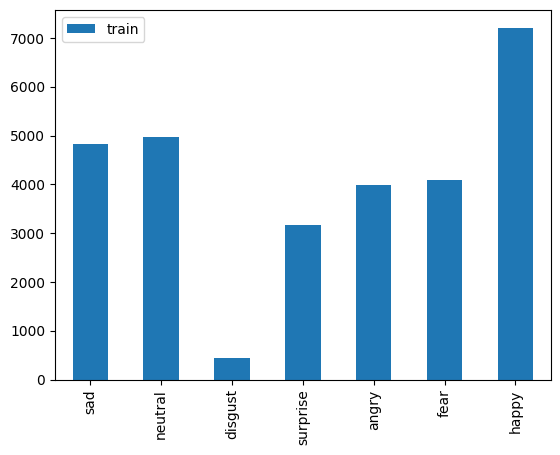

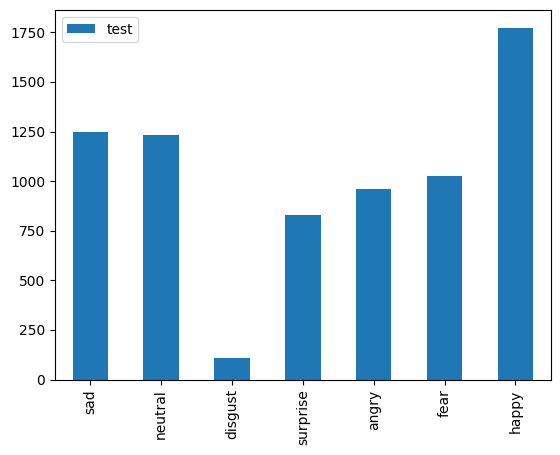

In [5]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

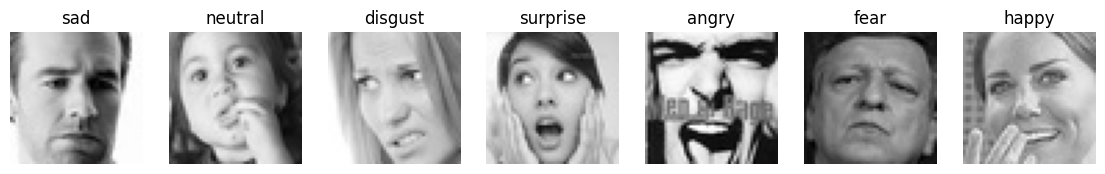

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_path):
    img = load_img((train_path + expression +'/'+ os.listdir(train_path + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

training_set.class_indices

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
def get_model(input_size, classes=7):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_size))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(7, activation='softmax'))


    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                        

In [10]:
# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)


In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=15,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 2.3449 - accuracy: 0.2695
Epoch 1: val_accuracy improved from -inf to 0.21164, saving model to model_weights.h5
448/448 [==============================] - 589s 1s/step - loss: 2.3449 - accuracy: 0.2695 - val_loss: 2.2323 - val_accuracy: 0.2116
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.9852 - accuracy: 0.3367
Epoch 2: val_accuracy improved from 0.21164 to 0.41350, saving model to model_weights.h5
448/448 [==============================] - 578s 1s/step - loss: 1.9852 - accuracy: 0.3367 - val_loss: 1.6331 - val_accuracy: 0.4135
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.8336 - accuracy: 0.3714
Epoch 3: val_accuracy improved from 0.41350 to 0.47196, saving model to model_weights.h5
448/448 [==============================] - 569s 1s/step - loss: 1.8336 - accuracy: 0.3714 - val_loss: 1.4297 - val_accuracy: 0.4720
Epoch 4/15
448/448 [==============================] 

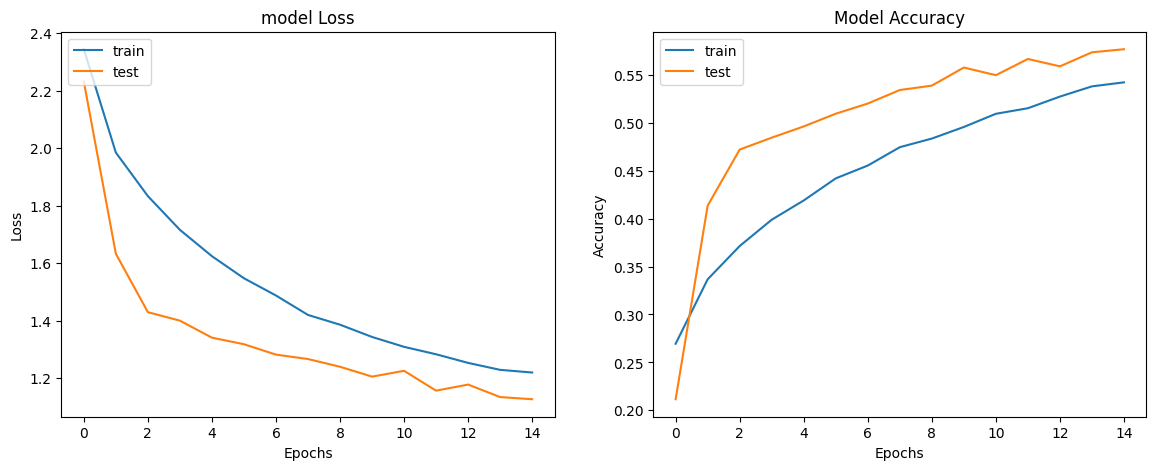

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
train_loss, train_accuracy = fernet.evaluate(training_set)
test_loss, test_accuracy = fernet.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

113/113 [==============================] - 35s 306ms/step - loss: 1.1262 - accuracy: 0.5765
Train accuracy = 58.85 , Test accuracy = 57.65


449/449 [==============================] - 141s 313ms/step
Training Set Confusion Matrix
[[ 566   12  373  952  758  866  468]
 [  55    3   42  122   80   73   61]
 [ 497   20  390 1064  767  831  528]
 [ 926   21  634 1815 1371 1548  900]
 [ 619   18  467 1184  967 1074  636]
 [ 689   14  457 1139  874 1071  586]
 [ 420   17  270  799  570  702  393]]
Training Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.14      0.15      3995
     disgust       0.03      0.01      0.01       436
        fear       0.15      0.10      0.12      4097
       happy       0.26      0.25      0.25      7215
     neutral       0.18      0.19      0.19      4965
         sad       0.17      0.22      0.19      4830
    surprise       0.11      0.12      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.15      0.15     28709
weighted avg       0.18      0.18      0.18     28709



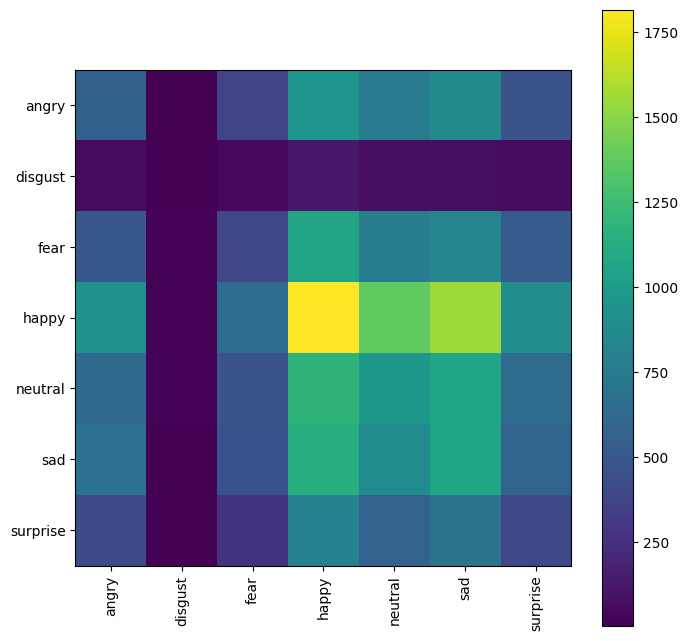

In [14]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Training Set Confusion Matrix')
print(cm_train)
print('Training Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 [==============================] - 34s 303ms/step
Testing Confusion Matrix
[[137   4 115 217 201 159 125]
 [ 16   1   7  29  20  20  18]
 [160   5 126 218 219 157 139]
 [266   8 197 410 376 284 233]
 [194   2 127 288 270 169 183]
 [198   8 125 308 250 177 181]
 [111   5  93 193 181 153  95]]
Testing Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       958
     disgust       0.03      0.01      0.01       111
        fear       0.16      0.12      0.14      1024
       happy       0.25      0.23      0.24      1774
     neutral       0.18      0.22      0.20      1233
         sad       0.16      0.14      0.15      1247
    surprise       0.10      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



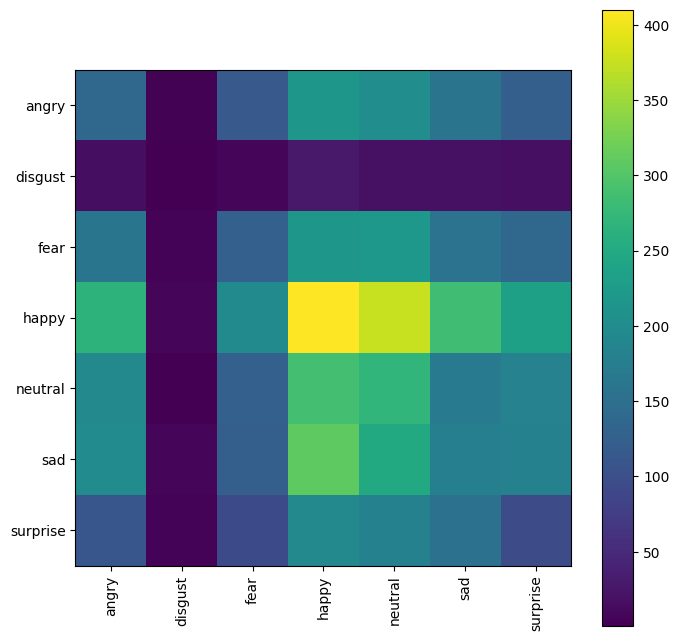

In [15]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Testing Confusion Matrix')
print(cm_test)
print('Testing Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)